In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Hexagonal Level Dataset

In [2]:
# import numpy as np
# import os
# from functools import partial
# import seaborn as sns
# import plotly.graph_objects as go
# import pandas as pd
# import dask.dataframe as dd
# import matplotlib.pyplot as plt
# import sys
# import pickle
# from pathlib import Path


# # hex2vec
# HOME = os.environ["HOME"]

# sys.path.insert(0, f"{HOME}/hex2vec")

# # add codebase
# sys.path.insert(0, f"/gcsmount-notebook/codebase")

# from src.data.make_dataset import h3_to_polygon
# import urban_tools.constants as uc
# from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
# from urban_tools.pipelines import route_hex_pipeline


# ## Read in the Delivery DataFrame
# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/debug-multi-synthetic-tags/hh.pkl")
# hh = RouteHexHandler.from_pickle(p)
# # embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

# ### Remove Super Tags
# # hh.drop_super_tags()
# ### Remove Sub Tags
# # hh = hh.drop_sub_tags()
# ### Filter for only H3 with > X Data Points

# hh = hh.filter_hex_occurance(20)
# ## Drop Unecessary Columns
# hh.other_tags
# ### Drop Chicago
# # print(tagged_df.shape[0].compute(), tagged_df.shape[1])
# # tagged_df = tagged_df.loc[~tagged_df["city"].str.contains("Chicago")]
# # filter for only Boston
# hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
# # print(tagged_df.shape[0].compute(), tagged_df.shape[1])

# ## Data Preprocessing: Scaling and Splitting into train test


# # create a grouped dataframe
# tagged_df = hh.df.groupby("h3").agg({
#     "planned_service_time_log": "mean",
#     **{
#         tag: "first"
#         for tag in hh.all_tags
#     }
# })


# from sklearn.preprocessing import RobustScaler

# tt = TestTrainManager(
#     tagged_df,
#     x_col=hh.all_tags,
#     y_col=["planned_service_time_log"],
#     scaler=RobustScaler,
#     grouped=True,
# )
# tt.split_test_train(train_size=0.8, random_seed=6781)


# tt.scale_test_train()
# tt.build_test_df(agg=False)

#### Delievery Level Dataset

In [2]:
import os
import sys
import pickle
from pathlib import Path
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
import seaborn as sns
import gc
from numpy.random import binomial
from numpy.random import normal

import pandas as pd
import seaborn as sns

# %reset -s -f
import os
from functools import partial
import logging

# hex2vec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{HOME}/hex2vec")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline

p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/debug-multi-synthetic-tags/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
# embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

### Filter for only H3 with > X Data Points
hh = hh.filter_hex_occurance(20)
## Drop Unecessary Columns
hh.other_tags

## Data Preprocessing: Scaling and Splitting into train test

#### Create the Test-Train Manager
# filter for only Boston
from sklearn.preprocessing import RobustScaler
hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
tt = TestTrainManager(
        hh.df,
        scaler=RobustScaler,
        x_col=hh.all_tags,
        y_col=hh.df.columns.intersection(["planned_service_time_log"]),
    )

tt.split_test_train(random_seed=12323)
tt.scale_test_train()
tt.build_test_df()
train = pd.concat([tt.X_train, tt.Y_train], axis=1, copy=True)
test = pd.concat([tt.X_test, tt.Y_test.loc, tt.Y_test.scale], axis=1, copy=True)

print(f'Training Data shape is {tt.X_train.shape}')
print(f'testing Data shape is {tt.X_test.shape}')

del hh
gc.collect()

# convert a pandas dataframe to a pytorch dataset
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, x_df, y_df):
        self._x_df = x_df.values.astype(np.float32)
        self._y_df = y_df.values.astype(np.float32).ravel()

    def __len__(self):
        return len(self._x_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self._x_df[idx], self._y_df[idx]

Training Data shape is (28337, 674)
testing Data shape is (240, 674)


In [3]:
import sys
sys.path.append('/home/ext_navish_iitkgp_gmail_com/ganRegression/')

In [4]:
import importlib

import dataset, metrics, plotting, config, network
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from models import cgan_model
import numpy as np
import random

importlib.reload(network)
importlib.reload(dataset)
importlib.reload(metrics)
importlib.reload(plotting)
importlib.reload(config)
importlib.reload(cgan_model)

2022-11-22 16:08:07.290072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 16:08:07.821693: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 16:08:08.713716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-22 16:08:08.714014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

<module 'models.cgan_model' from '/home/ext_navish_iitkgp_gmail_com/ganRegression/models/cgan_model.py'>

In [5]:
import os

dataset_config = config.DatasetConfig(scenario="amazon-boston-dataset")

fig_dir = f"/gcsmount-notebook/navish/RegressionNN/figures/{dataset_config.scenario}"

try:
    os.mkdir(fig_dir)
    print(f"Directory {fig_dir} created ") 
except FileExistsError:
    print(f"Directory {fig_dir} already exists replacing files in this notebook")

Directory /gcsmount-notebook/navish/RegressionNN/figures/amazon-boston-dataset already exists replacing files in this notebook


In [6]:
random_seed = 1985

exp_config = config.Config(
    model=config.ModelConfig(activation="elu", lr_gen=1e-4, lr_disc=1e-4, dec_gen=0, dec_disc=0, 
                                optim_gen="Adam", optim_disc="Adam", z_input_size=32, random_seed=random_seed),
    training=config.TrainingConfig(n_epochs=1000, batch_size=128, n_samples=100),
    dataset=dataset_config,
    run=config.RunConfig(save_fig=1)
)

In [7]:
# Set random seed
np.random.seed(exp_config.model.random_seed)
random.seed(exp_config.model.random_seed)

import tensorflow as tf
tf.random.set_seed(exp_config.model.random_seed)

# gpu = tf.config.experimental.list_physical_devices('CPU')
# tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.values.ravel(), tt.X_test.values, tt.Y_test.loc.values

In [9]:
X_train.shape, X_test.shape

((28337, 674), (240, 674))

# XGBoost

##### Tuning XGBOOST

In [11]:
# from sklearn.model_selection import GridSearchCV, KFold
# import xgboost as xgb

# # XGBoost
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1,eta=0.3, learning_rate = 1e-3,
#                 max_depth = 5, alpha = 10, n_estimators = 2000, n_jobs=-1)

# params = {
#     'n_estimators': [200, 500, 2000],
#     'learning_rate': [1e-3, 0.05, 0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.5, 1]
# }

# gs2 = GridSearchCV(xg_reg, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='r2')
# # gs2 = GridSearchCV(xg_reg, params, n_jobs=-1, cv=KFold(n_splits=3), scoring='neg_root_mean_squared_error')

# gs2.fit(X_train, y_train)

# print('Best score:', gs2.best_score_)
# print('Best score:', gs2.best_params_)

In [12]:
# Taking in the tuned parameters
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, eta=0.3, learning_rate = 1e-2,
                max_depth = 5, alpha = 10, n_estimators = 500, n_jobs=-1,
                base_score=.5, booster='gbtree', gamma=1, reg_alpha=0.5, reg_lambda=5)

# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 1e-2,
#                  n_estimators = 2000, n_jobs=-1)

xg_reg.fit(X_train,y_train)

ypred_xgb_train = xg_reg.predict(X_train)
ypred_xg_test = xg_reg.predict(X_test)

xg_mae = mean_absolute_percentage_error(ypred_xg_test, y_test)
print(f'Mean Absolute Error: {xg_mae}')

cov_xg = np.mean((y_test - ypred_xg_test)**2)

metrics.gaussian_NLPD(y_test, ypred_xg_test, np.ones(len(ypred_xg_test)) * cov_xg, "XG")

print('Mean Prediction')
print(f"Train-RMSE: {mean_squared_error(y_train, ypred_xgb_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_xgb_train).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, ypred_xg_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_xg_test).round(2)}")

print('Variance-predicitions')
print(f'Test MAPE: {mean_absolute_percentage_error(tt.Y_test.scale, preds.variance**0.5):.3f}, Test RMSE: {mean_squared_error(tt.Y_test.scale, preds.variance**0.5, squared=False):.3f}, Test R2: {r2_score(tt.Y_test.scale, preds.variance**0.5):.3f}')

Mean Absolute Error: 3.1702377714905055
XG Gaussian NLPD: 1.0762571696533683
Train-RMSE: 0.44, Train-R2: 0.76
Test-RMSE: 0.71, Test-R2: 0.58


# GAN

In [14]:
cgan = cgan_model.CGAN(exp_config)
cgan.trainable = True
d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true = cgan.train(X_train, y_train, 
                                                                              epochs=exp_config.training.n_epochs,
                                                                              batch_size=exp_config.training.batch_size)

ypred_gan_test = cgan.predict(X_test)

4/4 [==============================] - 0s 2ms/step
Epoch: 0 / dLoss: 0.6947913765907288 / gLoss: 0.6295484304428101
4/4 [==============================] - 0s 2ms/step
Epoch: 1 / dLoss: 0.6744989156723022 / gLoss: 0.85857754945755
4/4 [==============================] - 0s 2ms/step
Epoch: 2 / dLoss: 0.6837207078933716 / gLoss: 0.6780507564544678
4/4 [==============================] - 0s 2ms/step
Epoch: 3 / dLoss: 0.6905632019042969 / gLoss: 0.6854803562164307
4/4 [==============================] - 0s 2ms/step
Epoch: 4 / dLoss: 0.7217313647270203 / gLoss: 0.6804604530334473
4/4 [==============================] - 0s 2ms/step
Epoch: 5 / dLoss: 0.7147838175296783 / gLoss: 0.6738148331642151
4/4 [==============================] - 0s 2ms/step
Epoch: 6 / dLoss: 0.6663473546504974 / gLoss: 0.7599091529846191
4/4 [==============================] - 0s 2ms/step
Epoch: 7 / dLoss: 0.6494643092155457 / gLoss: 0.740740954875946
4/4 [==============================] - 0s 2ms/step
Epoch: 8 / dLoss: 0.6299

2022-11-22 10:30:56.385158: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step
Epoch: 69 / dLoss: 0.7268051207065582 / gLoss: 0.6079687476158142
4/4 [==============================] - 0s 3ms/step
Epoch: 70 / dLoss: 0.7250091731548309 / gLoss: 0.6273022890090942
4/4 [==============================] - 0s 2ms/step
Epoch: 71 / dLoss: 0.7186019122600555 / gLoss: 0.6457971930503845
4/4 [==============================] - 0s 3ms/step
Epoch: 72 / dLoss: 0.703601747751236 / gLoss: 0.6793233752250671
4/4 [==============================] - 0s 3ms/step
Epoch: 73 / dLoss: 0.6990603506565094 / gLoss: 0.672539472579956
4/4 [==============================] - 0s 2ms/step
Epoch: 74 / dLoss: 0.6887165307998657 / gLoss: 0.7080675959587097
4/4 [==============================] - 0s 3ms/step
Epoch: 75 / dLoss: 0.6731278896331787 / gLoss: 0.7336691617965698
4/4 [==============================] - 0s 2ms/step
Epoch: 76 / dLoss: 0.6761340498924255 / gLoss: 0.7419648170471191
4/4 [==============================] - 0s 3ms/step
Epoch: 77 / dLo

2022-11-22 10:31:35.500267: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 103 / dLoss: 0.696805328130722 / gLoss: 0.6997591853141785
4/4 [==============================] - 0s 3ms/step
Epoch: 104 / dLoss: 0.6982206404209137 / gLoss: 0.6957757472991943
4/4 [==============================] - 0s 2ms/step
Epoch: 105 / dLoss: 0.6891413331031799 / gLoss: 0.7077434659004211
4/4 [==============================] - 0s 3ms/step
Epoch: 106 / dLoss: 0.6897892951965332 / gLoss: 0.6985134482383728
4/4 [==============================] - 0s 3ms/step
Epoch: 107 / dLoss: 0.6911541819572449 / gLoss: 0.694820761680603
4/4 [==============================] - 0s 3ms/step
Epoch: 108 / dLoss: 0.7002079486846924 / gLoss: 0.6864795684814453
4/4 [==============================] - 0s 2ms/step
Epoch: 109 / dLoss: 0.6941405534744263 / gLoss: 0.6963168382644653
4/4 [==============================] - 0s 2ms/step
Epoch: 110 / dLoss: 0.6930419504642487 / gLoss: 0.6761316657066345
4/4 [==============================] - 0s 2ms/step
Epoch: 

2022-11-22 10:31:48.936676: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:31:48.956512: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:31:49.112784: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step


2022-11-22 10:31:49.145846: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:31:49.306756: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:31:49.343575: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 115 / dLoss: 0.7035442590713501 / gLoss: 0.6770116090774536
4/4 [==============================] - 0s 3ms/step
Epoch: 116 / dLoss: 0.6976580619812012 / gLoss: 0.6780121326446533
4/4 [==============================] - 0s 3ms/step
Epoch: 117 / dLoss: 0.7026737332344055 / gLoss: 0.6677860021591187
4/4 [==============================] - 0s 3ms/step
Epoch: 118 / dLoss: 0.6950296461582184 / gLoss: 0.6772175431251526
4/4 [==============================] - 0s 2ms/step
Epoch: 119 / dLoss: 0.7031057775020599 / gLoss: 0.6747871041297913
4/4 [==============================] - 0s 3ms/step
Epoch: 120 / dLoss: 0.7078077793121338 / gLoss: 0.675862729549408
4/4 [==============================] - 0s 3ms/step
Epoch: 121 / dLoss: 0.6941416263580322 / gLoss: 0.6901257038116455
4/4 [==============================] - 0s 2ms/step
Epoch: 122 / dLoss: 0.6983484327793121 / gLoss: 0.680368959903717
4/4 [==============================] - 0s 3ms/step
Epoch: 

2022-11-22 10:32:03.157855: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:32:03.176157: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2022-11-22 10:32:03.209858: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step
Epoch: 127 / dLoss: 0.6945768296718597 / gLoss: 0.7013058662414551
4/4 [==============================] - 0s 2ms/step


2022-11-22 10:32:04.474054: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 128 / dLoss: 0.6947244107723236 / gLoss: 0.6891259551048279
4/4 [==============================] - 0s 2ms/step
Epoch: 129 / dLoss: 0.6937876641750336 / gLoss: 0.6941846609115601
4/4 [==============================] - 0s 2ms/step
Epoch: 130 / dLoss: 0.694627195596695 / gLoss: 0.7076928019523621
4/4 [==============================] - 0s 2ms/step
Epoch: 131 / dLoss: 0.6935707926750183 / gLoss: 0.6877443790435791
4/4 [==============================] - 0s 3ms/step
Epoch: 132 / dLoss: 0.6984842121601105 / gLoss: 0.695508599281311
4/4 [==============================] - 0s 2ms/step
Epoch: 133 / dLoss: 0.6979019641876221 / gLoss: 0.6883895993232727
4/4 [==============================] - 0s 2ms/step
Epoch: 134 / dLoss: 0.694016695022583 / gLoss: 0.6910829544067383
4/4 [==============================] - 0s 2ms/step
Epoch: 135 / dLoss: 0.7013303339481354 / gLoss: 0.6880768537521362
4/4 [==============================] - 0s 3ms/step
Epoch: 1

2022-11-22 10:32:47.865931: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step
Epoch: 166 / dLoss: 0.6942037045955658 / gLoss: 0.7057697772979736
4/4 [==============================] - 0s 2ms/step
Epoch: 167 / dLoss: 0.6927773356437683 / gLoss: 0.7156099081039429
4/4 [==============================] - 0s 2ms/step
Epoch: 168 / dLoss: 0.6887704730033875 / gLoss: 0.7004085779190063
4/4 [==============================] - 0s 2ms/step
Epoch: 169 / dLoss: 0.6868845820426941 / gLoss: 0.7149065732955933
4/4 [==============================] - 0s 2ms/step
Epoch: 170 / dLoss: 0.6909118592739105 / gLoss: 0.7121427059173584
4/4 [==============================] - 0s 2ms/step
Epoch: 171 / dLoss: 0.6909250020980835 / gLoss: 0.7058174014091492
4/4 [==============================] - 0s 3ms/step
Epoch: 172 / dLoss: 0.6924331188201904 / gLoss: 0.7087925672531128
4/4 [==============================] - 0s 2ms/step
Epoch: 173 / dLoss: 0.6894238293170929 / gLoss: 0.7023853063583374
4/4 [==============================] - 0s 4ms/step
Epoch

2022-11-22 10:33:30.459696: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 204 / dLoss: 0.6906632483005524 / gLoss: 0.6978540420532227
4/4 [==============================] - 0s 3ms/step
Epoch: 205 / dLoss: 0.6922305524349213 / gLoss: 0.6984057426452637
4/4 [==============================] - 0s 2ms/step
Epoch: 206 / dLoss: 0.687059223651886 / gLoss: 0.7117775082588196
4/4 [==============================] - 0s 3ms/step
Epoch: 207 / dLoss: 0.681625485420227 / gLoss: 0.7045994997024536
4/4 [==============================] - 0s 2ms/step
Epoch: 208 / dLoss: 0.6871920824050903 / gLoss: 0.7181576490402222
4/4 [==============================] - 0s 2ms/step
Epoch: 209 / dLoss: 0.6831472218036652 / gLoss: 0.7245184183120728
4/4 [==============================] - 0s 3ms/step
Epoch: 210 / dLoss: 0.6824555099010468 / gLoss: 0.7122879028320312
4/4 [==============================] - 0s 2ms/step
Epoch: 211 / dLoss: 0.6873515546321869 / gLoss: 0.7211208343505859
4/4 [==============================] - 0s 2ms/step
Epoch: 

2022-11-22 10:33:56.178887: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 3ms/step
Epoch: 226 / dLoss: 0.6748318672180176 / gLoss: 0.7512480020523071
4/4 [==============================] - 0s 3ms/step
Epoch: 227 / dLoss: 0.6775541305541992 / gLoss: 0.7696342468261719
4/4 [==============================] - 0s 2ms/step
Epoch: 228 / dLoss: 0.6953458487987518 / gLoss: 0.7158302068710327
4/4 [==============================] - 0s 3ms/step
Epoch: 229 / dLoss: 0.6911559700965881 / gLoss: 0.7245259284973145
4/4 [==============================] - 0s 2ms/step
Epoch: 230 / dLoss: 0.6962599456310272 / gLoss: 0.7124514579772949
4/4 [==============================] - 0s 2ms/step
Epoch: 231 / dLoss: 0.7023258209228516 / gLoss: 0.6988039016723633
4/4 [==============================] - 0s 2ms/step
Epoch: 232 / dLoss: 0.707173615694046 / gLoss: 0.6744944453239441
4/4 [==============================] - 0s 3ms/step
Epoch: 233 / dLoss: 0.7034160494804382 / gLoss: 0.695764422416687
4/4 [==============================] - 0s 3ms/step
Epoch: 

2022-11-22 10:34:22.249011: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step


2022-11-22 10:34:22.523970: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 2ms/step
Epoch: 249 / dLoss: 0.691728264093399 / gLoss: 0.6987272500991821
4/4 [==============================] - 0s 2ms/step
Epoch: 250 / dLoss: 0.6995410621166229 / gLoss: 0.6922355890274048
4/4 [==============================] - 0s 2ms/step
Epoch: 251 / dLoss: 0.6954381167888641 / gLoss: 0.6825981140136719
4/4 [==============================] - 0s 2ms/step
Epoch: 252 / dLoss: 0.696570873260498 / gLoss: 0.6879091262817383
4/4 [==============================] - 0s 2ms/step
Epoch: 253 / dLoss: 0.7050126194953918 / gLoss: 0.6791517734527588
4/4 [==============================] - 0s 2ms/step
Epoch: 254 / dLoss: 0.698376476764679 / gLoss: 0.6847826838493347
4/4 [==============================] - 0s 2ms/step
Epoch: 255 / dLoss: 0.6836873590946198 / gLoss: 0.7037634253501892
4/4 [==============================] - 0s 2ms/step
Epoch: 256 / dLoss: 0.6777801513671875 / gLoss: 0.6980925798416138
4/4 [==============================] - 0s 2ms/step
Epoch: 2

2022-11-22 10:34:46.224409: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 268 / dLoss: 0.6897760629653931 / gLoss: 0.6917767524719238
4/4 [==============================] - 0s 3ms/step
Epoch: 269 / dLoss: 0.6928908228874207 / gLoss: 0.6797856092453003
4/4 [==============================] - 0s 2ms/step
Epoch: 270 / dLoss: 0.6929827630519867 / gLoss: 0.6748197078704834
4/4 [==============================] - 0s 3ms/step
Epoch: 271 / dLoss: 0.7023312151432037 / gLoss: 0.6696578860282898
4/4 [==============================] - 0s 2ms/step
Epoch: 272 / dLoss: 0.7005179226398468 / gLoss: 0.6629748940467834
4/4 [==============================] - 0s 3ms/step
Epoch: 273 / dLoss: 0.7041816115379333 / gLoss: 0.677104115486145
4/4 [==============================] - 0s 3ms/step
Epoch: 274 / dLoss: 0.69673091173172 / gLoss: 0.6696598529815674
4/4 [==============================] - 0s 2ms/step
Epoch: 275 / dLoss: 0.702422708272934 / gLoss: 0.6610443592071533
4/4 [==============================] - 0s 2ms/step
Epoch: 276 / dLoss: 0.7001639902591705 / gLoss: 0.6663833856

2022-11-22 10:35:09.429888: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 286 / dLoss: 0.6913573443889618 / gLoss: 0.7136340141296387
4/4 [==============================] - 0s 3ms/step
Epoch: 287 / dLoss: 0.6934078931808472 / gLoss: 0.6948341131210327
4/4 [==============================] - 0s 2ms/step
Epoch: 288 / dLoss: 0.6975110769271851 / gLoss: 0.6835449934005737
4/4 [==============================] - 0s 3ms/step
Epoch: 289 / dLoss: 0.7002653777599335 / gLoss: 0.6974820494651794
4/4 [==============================] - 0s 3ms/step
Epoch: 290 / dLoss: 0.6989147365093231 / gLoss: 0.7105644345283508
4/4 [==============================] - 0s 2ms/step
Epoch: 291 / dLoss: 0.7113539576530457 / gLoss: 0.6760226488113403
4/4 [==============================] - 0s 3ms/step
Epoch: 292 / dLoss: 0.7056327164173126 / gLoss: 0.6852405071258545
4/4 [==============================] - 0s 3ms/step
Epoch: 293 / dLoss: 0.6995385885238647 / gLoss: 0.6929130554199219
4/4 [==============================] - 0s 3ms/step
Epoch: 294 / dLoss: 0.7006528675556183 / gLoss: 0.693068

2022-11-22 10:36:08.183522: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 336 / dLoss: 0.6856290102005005 / gLoss: 0.6890902519226074
4/4 [==============================] - 0s 2ms/step
Epoch: 337 / dLoss: 0.68583944439888 / gLoss: 0.6915991902351379
4/4 [==============================] - 0s 3ms/step
Epoch: 338 / dLoss: 0.6900125443935394 / gLoss: 0.6928778886795044
4/4 [==============================] - 0s 2ms/step
Epoch: 339 / dLoss: 0.687265157699585 / gLoss: 0.7038138508796692
4/4 [==============================] - 0s 3ms/step
Epoch: 340 / dLoss: 0.6810910701751709 / gLoss: 0.694751501083374
4/4 [==============================] - 0s 3ms/step
Epoch: 341 / dLoss: 0.6875266432762146 / gLoss: 0.7053492069244385
4/4 [==============================] - 0s 2ms/step
Epoch: 342 / dLoss: 0.6794898509979248 / gLoss: 0.6983505487442017
4/4 [==============================] - 0s 2ms/step
Epoch: 343 / dLoss: 0.6640277802944183 / gLoss: 0.7392711639404297
4/4 [==============================] - 0s 3ms/step
Epoch: 344 / dLoss: 0.6871592700481415 / gLoss: 0.6772342920

2022-11-22 10:36:18.172394: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


Epoch: 345 / dLoss: 0.7049576342105865 / gLoss: 0.7068589925765991
4/4 [==============================] - 0s 3ms/step
Epoch: 346 / dLoss: 0.6806232333183289 / gLoss: 0.7365552186965942
4/4 [==============================] - 0s 3ms/step
Epoch: 347 / dLoss: 0.6908547580242157 / gLoss: 0.6725224256515503
4/4 [==============================] - 0s 3ms/step
Epoch: 348 / dLoss: 0.6993428766727448 / gLoss: 0.6820523142814636
4/4 [==============================] - 0s 3ms/step
Epoch: 349 / dLoss: 0.6940907537937164 / gLoss: 0.7036672234535217
4/4 [==============================] - 0s 3ms/step
Epoch: 350 / dLoss: 0.7040945291519165 / gLoss: 0.6722315549850464
4/4 [==============================] - 0s 3ms/step
Epoch: 351 / dLoss: 0.708329975605011 / gLoss: 0.660438597202301
4/4 [==============================] - 0s 3ms/step
Epoch: 352 / dLoss: 0.7113394141197205 / gLoss: 0.6867184638977051
4/4 [==============================] - 0s 2ms/step
Epoch: 353 / dLoss: 0.6987406015396118 / gLoss: 0.68942046

KeyboardInterrupt: 

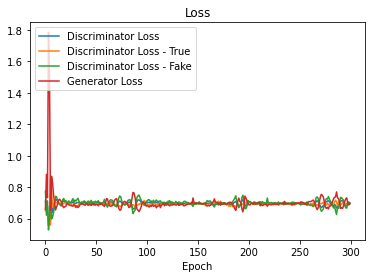

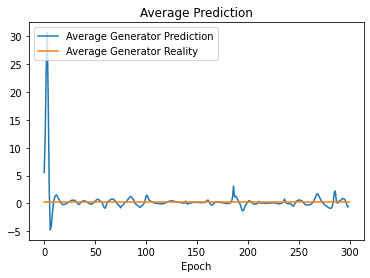

In [ ]:
plotting.plots(d_loss_err, d_loss_true, d_loss_fake, g_loss_err, g_pred, g_true, fig_dir, exp_config.run.save_fig)

In [ ]:
ypred_mean_gan_test, ypred_std_gan_test, ypred_gan_sample_test = cgan.sample(X_test, exp_config.training.n_samples)

8/8 [==============================] - 0s 2ms/step


In [16]:
ypred_mean_gan_train, ypred_std_gan_train, ypred_gan_sample_train = cgan.sample(X_train, exp_config.training.n_samples)

30/30 [==============================] - 0s 2ms/step


In [17]:
print(f"Train-RMSE: {mean_squared_error(y_train, ypred_mean_gan_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_mean_gan_train).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, ypred_mean_gan_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_mean_gan_test).round(2)}")

Train-RMSE: 1.08, Train-R2: -0.43
Test-RMSE: 1.25, Test-R2: -0.32


### Variance Prediction with CGAN

In [18]:
# print('GAN Variance-predicitions')
# print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, np.exp(0.5 * ypred_std_gan_test), squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, np.exp(0.5 * ypred_std_gan_test)).round(2)}")

# NN

In [19]:
import keras

# dropout_rate = 0.1
# 16, 32, 128, 32, 16

# Comparable architecture to GAN 
model = keras.models.Sequential([
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:]),
    # keras.layers.Dropout(dropout_rate), 
    keras.layers.Dense(32, activation="relu"),
    # keras.layers.Dropout(dropout_rate), 
    keras.layers.Dense(128, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(32, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(16, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    # keras.layers.Dense(50, activation="relu"),
    # keras.layers.Dropout(dropout_rate),
    # keras.layers.Dense(1, activation="relu"),
    keras.layers.Dense(1, activation="linear"),
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=1e-5, decay=1e-4))

In [20]:
# callbacks = [keras.callbacks.EarlyStopping(patience=10)]
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test), epochs=exp_config.training.n_epochs,)
                    # callbacks=callbacks)

Epoch 1/300
30/30 [==============================] - 1s 10ms/step - loss: 14.2416 - val_loss: 3.4921
Epoch 2/300
30/30 [==============================] - 0s 4ms/step - loss: 4.6380 - val_loss: 1.7453
Epoch 3/300
30/30 [==============================] - 0s 4ms/step - loss: 1.3433 - val_loss: 1.2535
Epoch 4/300
30/30 [==============================] - 0s 4ms/step - loss: 0.8318 - val_loss: 1.1399
Epoch 5/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7847 - val_loss: 1.1266
Epoch 6/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7822 - val_loss: 1.1313
Epoch 7/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7796 - val_loss: 1.1280
Epoch 8/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7774 - val_loss: 1.1239
Epoch 9/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7744 - val_loss: 1.1219
Epoch 10/300
30/30 [==============================] - 0s 4ms/step - loss: 0.7757 - val_loss: 1.1131
Epoch 1

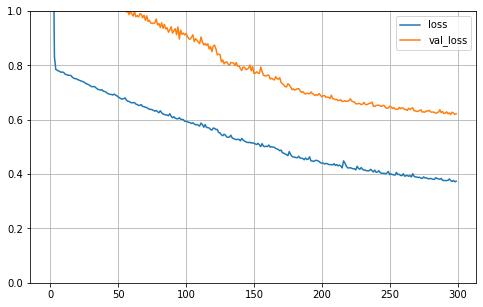

In [21]:
plotting.plot_learning_curves(history)

In [22]:
ypred_nn_train = model.predict(X_train)
ypred_nn_test = model.predict(X_test)

8/8 [==============================] - 0s 2ms/step


In [23]:
print(f"Train-RMSE: {mean_squared_error(y_train, ypred_nn_train, squared=False).round(2)}, Train-R2: {r2_score(y_train, ypred_nn_train).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, ypred_nn_test, squared=False).round(2)}, Test-R2: {r2_score(y_test, ypred_nn_test).round(2)}")

Train-RMSE: 0.61, Train-R2: 0.55
Test-RMSE: 0.79, Test-R2: 0.48


# GP

In [24]:
# !pip install gpytorch
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [25]:
import math
import gpytorch


#  R2 =0.25, VAR = -.14
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(torch.Tensor(X_train), torch.Tensor(y_train), likelihood)

NameError: name 'torch' is not defined

In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(torch.Tensor(X_train))
    # Calc loss and backprop gradients
    loss = -mll(output, torch.Tensor(y_train))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 1.332   lengthscale: 0.693   noise: 0.693
Iter 2/100 - Loss: 1.342   lengthscale: 0.688   noise: 0.688
Iter 3/100 - Loss: 1.328   lengthscale: 0.687   noise: 0.683
Iter 4/100 - Loss: 1.331   lengthscale: 0.688   noise: 0.678
Iter 5/100 - Loss: 1.322   lengthscale: 0.691   noise: 0.673
Iter 6/100 - Loss: 1.321   lengthscale: 0.694   noise: 0.669
Iter 7/100 - Loss: 1.331   lengthscale: 0.698   noise: 0.664
Iter 8/100 - Loss: 1.328   lengthscale: 0.702   noise: 0.659
Iter 9/100 - Loss: 1.330   lengthscale: 0.706   noise: 0.654
Iter 10/100 - Loss: 1.317   lengthscale: 0.710   noise: 0.649
Iter 11/100 - Loss: 1.319   lengthscale: 0.714   noise: 0.644
Iter 12/100 - Loss: 1.314   lengthscale: 0.719   noise: 0.640
Iter 13/100 - Loss: 1.311   lengthscale: 0.723   noise: 0.635
Iter 14/100 - Loss: 1.307   lengthscale: 0.728   noise: 0.630
Iter 15/100 - Loss: 1.305   lengthscale: 0.732   noise: 0.626
Iter 16/100 - Loss: 1.303   lengthscale: 0.737   noise: 0.621
Iter 17/100 - Los

In [ ]:
f_preds = model(torch.Tensor(X_train))
y_preds = likelihood(model(torch.Tensor(X_train)))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
# f_samples = f_preds.sample(sample_shape=torch.Size(1000,))

In [ ]:

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(torch.Tensor(X_test)))

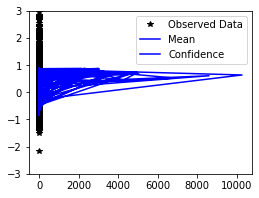

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(X_train[:,5], y_train, 'k*')
    # Plot predictive means as blue line
    ax.plot(X_test, observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test[:,0], lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
# ----------------- RBF ----------------- #
# ypred_gp_rbf_train = y_preds.mean.detach().numpy()
# ypred_gp_rbf_test, std_rbf_test = observed_pred.mean.numpy(), observed_pred.variance.numpy()**0.5

# # ----------------- RatQuad ----------------- #
ypred_gp_quad_train = y_preds.mean.detach().numpy()
ypred_gp_quad_test, std_quad_test = observed_pred.mean.numpy(), observed_pred.variance.numpy()**0.5

#### RBF predictions

In [ ]:
print('Mean-predicitions')
print(f"Train-RMSE: {mean_squared_error(y_train, y_preds.mean.detach().numpy(), squared=False).round(2)}, Train-R2: {r2_score(y_train, y_preds.mean.detach().numpy()).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, observed_pred.mean.numpy(), squared=False).round(2)}, Test-R2: {r2_score(y_test, observed_pred.mean.numpy()).round(2)}\n")

# print('Variance-predicitions')
# print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, observed_pred.variance.numpy()**0.5, squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, observed_pred.variance.numpy()**0.5).round(2)}")

Mean-predicitions
Train-RMSE: 1.01, Train-R2: -0.24
Test-RMSE: 0.94, Test-R2: 0.26



#### RQKernel predictions

In [ ]:
print('Mean-predicitions')
print(f"Train-RMSE: {mean_squared_error(y_train, y_preds.mean.detach().numpy(), squared=False).round(2)}, Train-R2: {r2_score(y_train, y_preds.mean.detach().numpy()).round(2)}")
print(f"Test-RMSE: {mean_squared_error(y_test, observed_pred.mean.numpy(), squared=False).round(2)}, Test-R2: {r2_score(y_test, observed_pred.mean.numpy()).round(2)}\n")

# print('Variance-predicitions')
# print(f"Test-RMSE: {mean_squared_error(tt.Y_test.scale, observed_pred.variance.numpy()**0.5, squared=False).round(2)}, Test-R2: {r2_score(tt.Y_test.scale, observed_pred.variance.numpy()**0.5).round(2)}")

Mean-predicitions
Train-RMSE: 1.01, Train-R2: -0.24
Test-RMSE: 0.94, Test-R2: 0.26



# Plots

In [ ]:
# plotting.plot_densities_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_test, 
#                              "Linear-vs-GAN-vs-GP P(y) density", fig_dir=fig_dir, 
#                              prefix="all_marginalized", save_fig=exp_config.run.save_fig, at_x=True)

plotting.plot_datadistrib_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_rbf_test, 
                                "Linear-vs-GAN-vs-GP_rbf | P(y) density", fig_dir=fig_dir, 
                                prefix="all_marginalized", save_fig=exp_config.run.save_fig)

plotting.plot_datadistrib_joint(y_test, ypred_nn_test, ypred_mean_gan_test, ypred_gp_quad_test, 
                                "Linear-vs-GAN-vs-GP_quad | P(y) density", fig_dir=fig_dir, 
                                prefix="all_marginalized", save_fig=exp_config.run.save_fig)

NameError: name 'ypred_nn_test' is not defined

# Metrics

In [ ]:
n_eval_runs = 10

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

mse_gan_= []
mae_gan_ = []
r2_gan_ = []
for i in range(n_eval_runs):
    ypred_mean_gan_test_, ypred_median_gan_test_, _ = cgan.sample(X_test, exp_config.training.n_samples)
    mae_gan_.append(mean_absolute_percentage_error(y_test, ypred_median_gan_test_))
    mse_gan_.append(mean_squared_error(y_test, ypred_mean_gan_test_, squared=False))
    r2_gan_.append(r2_score(y_test, ypred_mean_gan_test_))

8/8 [==============================] - 0s 2ms/step


In [ ]:
nn_mae = mean_absolute_percentage_error(y_test, ypred_nn_test)
gp_rbf_mae = mean_absolute_percentage_error(y_test, ypred_gp_rbf_test)
gp_quad_mae = mean_absolute_percentage_error(y_test, ypred_gp_quad_test)
gan_mae_mean = np.mean(np.asarray(mae_gan_))
gan_mae_std = np.std(np.asarray(mae_gan_))

print(f"NN MAE test: {nn_mae}")
print(f"GP MAE test: RBF = {gp_rbf_mae}, QUAD = {gp_quad_mae}")
print(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}")

NN MAE test: 0.5718941009207605
GP MAE test: RBF = 0.6662740466446093, QUAD = 0.6308358479949356
GAN MAE test: 0.6276623772377045 +- 0.003605090236830058


In [ ]:
nn_mse = mean_squared_error(y_test, ypred_nn_test).round(2)
gp_rbf_mse = mean_squared_error(y_test, ypred_gp_rbf_test).round(2)
gp_quad_mse = mean_squared_error(y_test, ypred_gp_quad_test).round(2)
gan_mse_mean = np.mean(np.asarray(mse_gan_)).round(2)
gan_mse_std = np.std(np.asarray(mse_gan_)).round(2)
# mdn_mse_mean = np.mean(np.asarray(mse_mdn_))
# mdn_mse_std = np.std(np.asarray(mse_mdn_))

print(f"NN MSE test: {nn_mse}")
print(f"GP MSE test: RBF = {gp_rbf_mse}, QUAD = {gp_quad_mse}")
print(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}")
# print(f"MDN MSE test: {mdn_mse_mean} +- {mdn_mse_std}")

NN MSE test: 0.59
GP MSE test: RBF = 1.04, QUAD = 0.84
GAN MSE test: 0.89 +- 0.0


In [ ]:
nn_r2 = r2_score(y_test, ypred_nn_test).round(2)
gp_rbf_r2 = r2_score(y_test, ypred_gp_rbf_test).round(2)
gp_quad_r2 = r2_score(y_test, ypred_gp_quad_test).round(2)
gan_r2_mean = np.mean(np.asarray(r2_gan_)).round(2)
gan_r2_std = np.std(np.asarray(r2_gan_)).round(2)

print(f"NN R2 test: {nn_r2}")
print(f"GP R2 test: RBF = {gp_rbf_r2}, QUAD = {gp_quad_r2}")
print(f"GAN R2 test: {gan_r2_mean} +- {gan_r2_std}")
# print(f"MDN MSE test: {mdn_mse_mean} +- {mdn_mse_std}")

NN R2 test: 0.51
GP R2 test: RBF = 0.12, QUAD = 0.29
GAN R2 test: 0.33 +- 0.0


In [ ]:
cov_nn = np.mean((y_test - ypred_nn_test)**2)
nn_nlpd = metrics.gaussian_NLPD(y_test, ypred_nn_test, np.ones(len(ypred_nn_test)) * cov_nn, "NN")

NN Gaussian NLPD: 1.3706085406456683


In [ ]:
gp_rbf_nlpd = metrics.gaussian_NLPD(y_test, ypred_gp_rbf_test, cov_rbf_train, "GP-RBF")
gp_quad_nlpd = metrics.gaussian_NLPD(y_test, ypred_gp_quad_test, cov_quad_train, "GP-QUAD")

GP-RBF Gaussian NLPD: 1.7281478367684642
GP-QUAD Gaussian NLPD: 1.5208828884339085


In [ ]:
gan_nlpd_train, w, lls = metrics.Parzen(cgan, X_train, y_train, n_sample=exp_config.training.n_samples)
nlpd_ = []
for i in range(n_eval_runs):
    nlpd_.append(metrics.Parzen_test(cgan, X_test, y_test, w, exp_config.training.n_samples))
gan_nlpd_test = np.mean(nlpd_)
gan_nlpd_std_test = np.std(nlpd_)

2/2 [==============================] - 0s 4ms/step


In [ ]:
print(f"GAN Train NLLH: {gan_nlpd_train}")
print(f"GAN Test NLLH: mean {gan_nlpd_test} std {gan_nlpd_std_test}")

GAN Train NLLH: 1.0688424955559799
GAN Test NLLH: mean 1.405695862654206 std 0.008065419764411764


In [ ]:
if exp_config.run.save_fig:
    file = open(f"{fig_dir}/metrics.txt","w") 

    file.write(f"===Test MAE===\n")
    file.write(f"NN MAE test: {nn_mae}\n") 
    file.write(f"GP MAE test: RBF = {gp_rbf_mae}, QUAD = {gp_quad_mae}\n")
    file.write(f"GAN MAE test: {gan_mae_mean} +- {gan_mae_std}\n")
    file.write(f"===Test MSE===\n")
    file.write(f"NN MSE test: {nn_mse}\n")
    file.write(f"GP MSE test: RBF = {gp_rbf_mse}, QUAD = {gp_quad_mse}\n")
    file.write(f"GAN MSE test: {gan_mse_mean} +- {gan_mse_std}\n")
    file.write(f"===Test R2===\n")
    file.write(f"NN R2 test: {nn_r2}\n")
    file.write(f"GP R2 test: RBF = {gp_rbf_r2}, QUAD = {gp_quad_r2}\n")
    file.write(f"GAN R2 test: {gan_r2_mean} +- {gan_r2_std}\n")
    file.write(f"===Test NLPD===\n")
    file.write(f"NN Gaussian NLPD: {nn_nlpd}\n")
    file.write(f"GP Gaussian NLPD: RBF = {gp_rbf_nlpd}, QUAD = {gp_quad_nlpd}\n")
    file.write(f"GAN NLPD: {gan_nlpd_test} +- {gan_nlpd_std_test}\n")
    file.close() 

In [ ]:
ypred_mean_gan_train.shape

(957, 1)

In [ ]:
# Training covariances
cov_nn_train = np.mean((y_train - ypred_nn_train)**2)
cov_xgb_train = np.mean((y_train - ypred_xgb_train)**2)

# ----------------- Finding Training Losses -----------------
nn_r2_train, nn_mse_train, nn_mae_train, nn_nlpd_train = r2_score(y_train, ypred_nn_train), mean_squared_error(y_train, ypred_nn_train), mean_absolute_percentage_error(y_train, ypred_nn_train), metrics.gaussian_NLPD(y_train, ypred_nn_train, np.ones(len(ypred_nn_train)) * cov_nn_train, "NN")
gp_rbf_r2_train, gp_rbf_mse_train, gp_rbf_mae_train, gp_rbf_nlpd_train = r2_score(y_train, ypred_gp_rbf_train), mean_squared_error(y_train, ypred_gp_rbf_train), mean_absolute_percentage_error(y_train, ypred_gp_rbf_train), metrics.gaussian_NLPD(y_train, ypred_gp_rbf_train, cov_rbf_train, "GP-RBF")
gp_quad_r2_train, gp_quad_mse_train, gp_quad_mae_train, gp_quad_nlpd_train = r2_score(y_train, ypred_gp_quad_train), mean_squared_error(y_train, ypred_gp_quad_train), mean_absolute_percentage_error(y_train, ypred_gp_quad_train), metrics.gaussian_NLPD(y_train, ypred_gp_quad_train, cov_quad_train, "GP-QUAD")
gan_r2_train, gan_mse_train, gan_mae_train, gan_nlpd_train = r2_score(y_train, ypred_mean_gan_train), mean_squared_error(y_train, ypred_mean_gan_train), mean_absolute_percentage_error(y_train, ypred_mean_gan_train), gan_nlpd_train
xgb_r2_train, xgb_mse_train, xgb_mae_train, xgb_nlpd_train = r2_score(y_train, ypred_xgb_train), mean_squared_error(y_train, ypred_xgb_train), mean_absolute_percentage_error(y_train, ypred_xgb_train), metrics.gaussian_NLPD(y_train, ypred_xgb_train, np.ones(len(ypred_xgb_train)) * cov_xgb_train, "XGB")

# ----------------- Finding Test Losses for XGBOOST -----------------
cov_xgb_test = np.mean((y_test - ypred_xg_test)**2)
xgb_r2, xgb_mse, xgb_mae, xgb_nlpd = r2_score(y_test, ypred_xg_test), mean_squared_error(y_test, ypred_xg_test), mean_absolute_percentage_error(y_test, ypred_xg_test), metrics.gaussian_NLPD(y_test, ypred_xg_test, np.ones(len(ypred_xg_test)) * cov_xgb_test, "XGB")

results = {
    "NN": {'Train': {'R2':nn_r2_train.round(2), "RMSE":nn_mse_train.round(2), "MAE":nn_mae_train.round(2), "NLPD":nn_nlpd_train.round(2)}, 'Test': {'R2':nn_r2.round(2), "RMSE":nn_mse.round(2), "MAE":nn_mae.round(2), "NLPD":nn_nlpd.round(2)}},
    "GP-RBF": {'Train': {'R2':gp_rbf_r2_train.round(2), "RMSE":gp_rbf_mse_train.round(2), "MAE":gp_rbf_mae_train.round(2), "NLPD":gp_rbf_nlpd_train.round(2)}, 'Test': {'R2':gp_rbf_r2.round(2), "RMSE":gp_rbf_mse.round(2), "MAE":gp_rbf_mae.round(2), "NLPD":gp_rbf_nlpd.round(2)}},
    "GP-QUAD": {'Train': {'R2':gp_quad_r2_train.round(2), "RMSE":gp_quad_mse_train.round(2), "MAE":gp_quad_mae_train.round(2), "NLPD":gp_quad_nlpd_train.round(2)}, 'Test': {'R2':gp_quad_r2.round(2), "RMSE":gp_quad_mse.round(2), "MAE":gp_quad_mae.round(2), "NLPD":gp_quad_nlpd.round(2)}},
    "CGAN": {'Train': {'R2':gan_r2_train.round(2), "RMSE":gan_mse_train.round(2), "MAE":gan_mae_train.round(2), "NLPD":gan_nlpd_train.round(2)}, 'Test': {'R2':gan_r2_mean.round(2), "RMSE":gan_mse_mean.round(2), "MAE":gan_mae_mean.round(2), "NLPD":gan_nlpd_test.round(2)}},
    "XGB": {'Train': {'R2':xgb_r2_train.round(2), "RMSE":xgb_mse_train.round(2), "MAE":xgb_mae_train.round(2), "NLPD":xgb_nlpd_train.round(2)}, 'Test': {'R2':xgb_r2.round(2), "RMSE":xgb_mse.round(2), "MAE":xgb_mae.round(2), "NLPD":xgb_nlpd.round(2)}},
}

NN Gaussian NLPD: 1.1458503378402647
GP-RBF Gaussian NLPD: 0.7350849333122246
GP-QUAD Gaussian NLPD: 0.6757093193808699
XGB Gaussian NLPD: 0.5952350083130847
XGB Gaussian NLPD: 1.0762571696533683


In [ ]:
pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')

R2  RMSE   MAE  NLPD
NN      Train  0.72  0.23  0.35  1.15
        Test   0.51  0.59  0.57  1.37
GP-RBF  Train  0.74  0.22  0.35  0.74
        Test   0.12  1.04  0.67  1.73
GP-QUAD Train  0.78  0.18  0.33  0.68
        Test   0.29  0.84  0.63  1.52
CGAN    Train  0.44  0.46  0.51  1.07
        Test   0.33  0.89  0.63  1.41
XGB     Train  0.76  0.19  0.34  0.60
        Test   0.58  0.50  0.52  1.08